In [70]:
from PIL import Image
import torchvision.transforms as T

In [71]:
mage = Image.open("/content/drive/MyDrive/Trafic_Dhaka.jpg")
transform = T.Compose([T.ToTensor()])
image_tensor = transform(image)

In [72]:
import torch

In [73]:
import torchvision.models as models
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights

# Load a Mask R-CNN model with specific weights
model = models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1)
model.eval()
# Check if GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [74]:
with torch.no_grad():
    predictions = model([image_tensor])

In [75]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(image, predictions, threshold=0.5):
    plt.imshow(image)
    for i, mask in enumerate(predictions[0]['masks']):
        if predictions[0]['scores'][i] > threshold:
            mask = mask[0].mul(255).byte().cpu().numpy()
            plt.imshow(mask, alpha=0.5)
    plt.show()

In [76]:
visualize_predictions(image, predictions)

In [77]:
import os

def save_segmented_objects(image, predictions, output_dir="segmented_objects", threshold=0.5):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, mask in enumerate(predictions[0]['masks']):
        if predictions[0]['scores'][i] > threshold:
            mask = mask[0].mul(255).byte().cpu().numpy()
            masked_image = np.array(image) * mask[:, :, np.newaxis]
            object_image = Image.fromarray(masked_image.astype(np.uint8))
            object_image.save(os.path.join(output_dir, f"object_{i}.png"))
            print(f"Saved object_{i}.png")

In [78]:
save_segmented_objects(image, predictions)

Saved object_0.png
Saved object_1.png
Saved object_2.png
Saved object_3.png
Saved object_4.png
Saved object_5.png
Saved object_6.png
Saved object_7.png
Saved object_8.png
Saved object_9.png
Saved object_10.png
Saved object_11.png
Saved object_12.png
Saved object_13.png
Saved object_14.png


In [79]:
pip install transformers

In [80]:
from transformers import CLIPProcessor, CLIPModel
import torch

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [81]:
def describe_objects(output_dir="segmented_objects"):
    descriptions = {}
    for filename in os.listdir(output_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(output_dir, filename)
            image = Image.open(image_path)
            inputs = processor(images=image, return_tensors="pt")
            outputs = model.get_text_features(**inputs)
            text = model.generate(inputs)
            descriptions[filename] = text

    return descriptions
    object_descriptions = describe_objects()

In [82]:
pip install pytesseract

In [83]:
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [84]:
import pytesseract
def extract_text_from_objects(output_dir="segmented_objects"):
    texts = {}
    for filename in os.listdir(output_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(output_dir, filename)
            text = pytesseract.image_to_string(image_path)
            texts[filename] = text

    return texts
object_texts = extract_text_from_objects()

In [85]:
from transformers import pipeline

# Specify the model name explicitly
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_object_attributes(object_texts):
    summaries = {}
    for filename, text in object_texts.items():
        try:
            # Generate the summary
            summary = summarizer(text, max_length=50, min_length=25, do_sample=False)
            summaries[filename] = summary[0]['summary_text']
        except Exception as e:
            print(f"Error summarizing text for {filename}: {e}")
            summaries[filename] = "Error summarizing text"

    return summaries

# Example usage
object_texts = {
    "example_file.txt": "This is an example text that needs to be summarized."
}

object_summaries = summarize_object_attributes(object_texts)
print(object_summaries)

Your max_length is set to 50, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


{'example_file.txt': 'This is an example text that needs to be summarized. This is anexample text that need to be summed up. Please share your own version of this text.'}


In [86]:
import json
import os

def create_data_mapping(object_descriptions, object_texts, object_summaries, output_dir="segmented_objects"):
    data_mapping = {}

    try:
        # Iterate over files in the specified directory
        for filename in os.listdir(output_dir):
            if filename.endswith(".png"):
                object_id = filename.split(".")[0]
                # Populate the data mapping dictionary
                data_mapping[object_id] = {
                    "description": object_descriptions.get(filename, ""),
                    "text": object_texts.get(filename, ""),
                    "summary": object_summaries.get(filename, "")
                }

        # Save the data mapping to a JSON file
        with open("data_mapping.json", "w") as f:
            json.dump(data_mapping, f, indent=4)
        print("Data mapping saved successfully.")

    except FileNotFoundError as e:
        print(f"Error: Directory not found: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage
object_descriptions = {"object1.png": "description1", "object2.png": "description2"}
object_texts = {"object1.png": "text1", "object2.png": "text2"}
object_summaries = {"object1.png": "summary1", "object2.png": "summary2"}

create_data_mapping(object_descriptions, object_texts, object_summaries)

Data mapping saved successfully.


In [87]:
pip install torch torchvision opencv-python transformers pillow

In [88]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import cv2
import numpy as np

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load a pre-trained object detection model (YOLOv5s in this case)
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Load an image
image_path = "/content/drive/MyDrive/Trafic_Dhaka.jpg"
image = cv2.imread(image_path)

# Check if the image was loaded correctly
if image is None:
    raise FileNotFoundError(f"Image file at path '{image_path}' not found or cannot be loaded.")

# Convert image to RGB and PIL format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

# Perform object detection
results = yolo_model(image_rgb)
detections = results.pandas().xyxy[0]  # Bounding boxes in Pandas DataFrame

# Define the list of labels for classification
labels = ["person", "car", "bus", "dog", "cat"]  # Extend this list based on your needs

# Draw bounding boxes and labels on the image
for index, row in detections.iterrows():
    x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
    cropped_img = image_pil.crop((x1, y1, x2, y2))

    # Preprocess the cropped image and labels
    inputs = clip_processor(images=cropped_img, text=labels, return_tensors="pt", padding=True)

    # Perform CLIP classification
    with torch.no_grad():
        # Forward pass through the model
        outputs = clip_model(**inputs)
        image_features = outputs.image_embeds
        text_features = outputs.text_embeds

        # Compute similarity
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        logits_per_image = torch.matmul(image_features, text_features.T) * 100.0

        # Softmax to get probabilities
        probs = logits_per_image.softmax(dim=1)

    # Get the label with the highest probability
    label_idx = torch.argmax(probs, dim=1).item()
    label = labels[label_idx]
    confidence = probs[0][label_idx].item()

    # Draw bounding box and label
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    text = f'{label} {confidence:.2f}'
    cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Save or display the result
output_image_path = 'output_image.jpg'
cv2.imwrite(output_image_path, image)
print(f'Result saved to {output_image_path}')


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-8-6 Python-3.10.12 torch-2.3.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Result saved to output_image.jpg


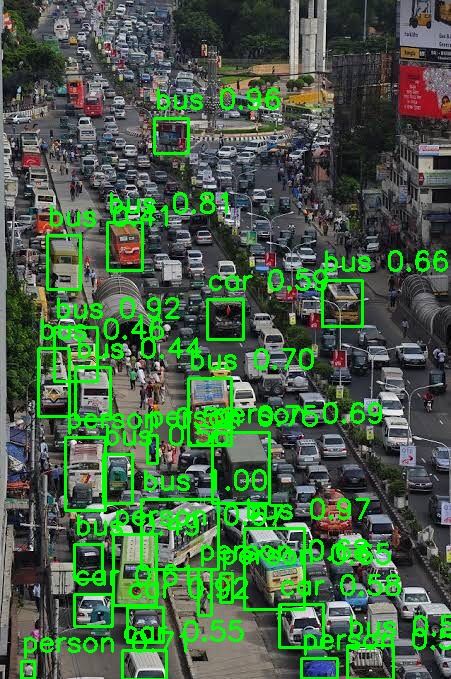

In [89]:
from google.colab.patches import cv2_imshow
import cv2

# Load the saved image
output_image_path = 'output_image.jpg'
output_image = cv2.imread(output_image_path)

# Display the image in Colab
cv2_imshow(output_image)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-8-6 Python-3.10.12 torch-2.3.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


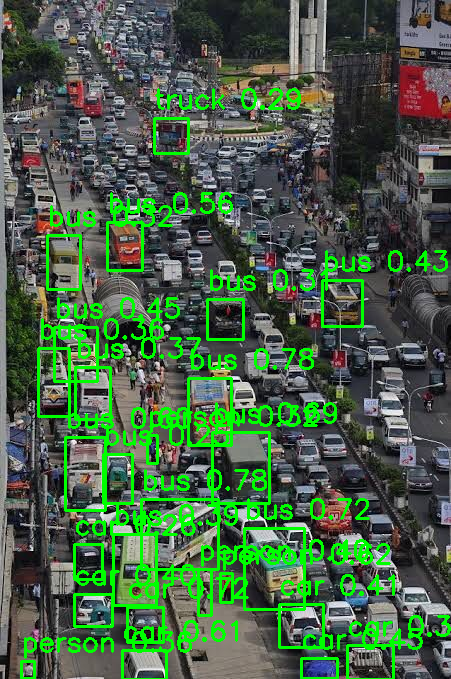

In [91]:
import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the YOLOv5 model from PyTorch Hub
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Load an image using OpenCV
image_path = "/content/drive/MyDrive/Trafic_Dhaka.jpg"   # Replace with your image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform inference
results = model(image_rgb)

# Parse the results
detections = results.pandas().xyxy[0]  # Bounding boxes in Pandas DataFrame

# Draw bounding boxes and labels on the image
for index, row in detections.iterrows():
    x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
    label = row['name']
    confidence = row['confidence']

    # Draw bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Put label and confidence
    text = f'{label} {confidence:.2f}'
    cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Save or display the result
cv2.imwrite('output_image.jpg', image)  # Save the result
cv2_imshow(image)  # Display the result in Colab